In [354]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output

In [370]:
# Get unit color distribution and ratio
def summon(desired_color, num_wanted, free_pull, start_percent, focus, random_pool):
    num_per_rarity = np.vstack((focus, random_pool[0,:]+random_pool[1,:], 
                                random_pool[1,:]+random_pool[2,:], random_pool[2,:]))
    ratio_in_rarity = np.true_divide(num_per_rarity, num_per_rarity.sum(axis=1, keepdims=True))

    num_pulled = 0
    pity_count = 0
    summoned = False
    orbs_spent = 0
    pity_breakers = 0
    while not summoned:
        # Generate 5 random numbers to simulate 5 stones
        pull = np.random.rand(5)
        # Get current pity rate
        pity_increase = int(pity_count / 5)
        # Current summon percentages
        curr_percent = ([start_percent[0] + pity_increase * .005 * start_percent[0] / (start_percent[0] + start_percent[1]),
                         start_percent[1] + pity_increase * .005 * start_percent[1] / (start_percent[0] + start_percent[1]),
                         start_percent[2] - pity_increase * .005 * start_percent[2] / (start_percent[2] + start_percent[3]),
                         start_percent[3] - pity_increase * .005 * start_percent[3] / (start_percent[2] + start_percent[3])])
        # Probability of drawing a specific color and rarity
        prob_of_draw = (ratio_in_rarity.T * curr_percent).T
        # Probability of specific color
        color_prob = sum(prob_of_draw)
        # Probability of rarity given color
#        prob_per_color = np.true_divide(prob_of_draw, color_prob)

        # Cutoffs to determine what color and rarity is pulled
        color_cutoff = np.add.accumulate(color_prob)
        rarity_cutoff = np.concatenate((np.array([0]), color_cutoff))
        # Generate color of orbs
        stone_color = []
        stone_remainder = []
        for i in range(0,5):
            stone_color.append(np.size(color_cutoff[(color_cutoff < pull[i])]))
            stone_remainder.append(pull[i] - rarity_cutoff[stone_color[i]])
        # Number of stones present for desired color
        wanted_stones = stone_color.count(desired_color)
        if wanted_stones > 0: # Pull desired color
            cost_index = 1
            pity_broken = False
            for i in range(0,5):
                if stone_color[i] == desired_color:
                    if not free_pull:
                        orbs_spent += 5 - int((cost_index + 1) / 3)
                    else:
                        free_pull = False
                    pity_count += 1
                    cost_index += 1
                    # Determine if pull was desired unit or pity broken
                    if stone_remainder[i] < np.true_divide(prob_of_draw[0][stone_color[i]],num_per_rarity[0][stone_color[i]]):
                        num_pulled += 1
                        if num_pulled == num_wanted:
                            summoned = True
                            # Completely stop summoning when desired unit pulled
                            break
                        pity_broken = True
                    elif stone_remainder[i] < prob_of_draw[0][stone_color[i]] + prob_of_draw[1][stone_color[i]]:
                        pity_breakers += 1
                        pity_broken = True
            if pity_broken:
                pity_count = 0
        else: # Pull alternative color because desired color not present
            color_not_present = np.invert(np.in1d([0, 1, 2, 3], stone_color))
            break_prob = np.true_divide(prob_of_draw[0] + prob_of_draw[1], color_prob)
            alt_color = np.argmin(break_prob + color_not_present)
            for i in range(0,5):
                if stone_color[i] == alt_color:
                    if not free_pull:
                        orbs_spent += 5
                    else:
                        free_pull = False
                    pity_count += 1
                    # Pity break if 5* summoned
                    if stone_remainder[i] < prob_of_draw[0][stone_color[i]] + prob_of_draw[1][stone_color[i]]:
                        pity_breakers += 1
                        pity_count = 0
                    break
    #     print(pull)
    #     print(rarity_cutoff)
    #     print(stone_color)
    #     print(stone_remainder)

    # print(orbs_spent)
    # print(pity_breakers)
    return orbs_spent

In [397]:
start_percent = np.array([0.03, 0.03, 0.58, 0.36])
focus = np.array([1, 1, 1 , 0]) # R, B, G, C
# start_percent = np.array([0.08, 0.00, 0.58, 0.34])
# focus = np.array([3, 3, 3 , 3]) # R, B, G, C
random_pool = np.array([[25, 15, 11, 8],  #5* exclusive
                        [15, 15, 9, 12],  #4-5*
                        [15, 12, 9, 13]]) #3-4*

free_pull = False
num_wanted = 1 # 1 for 5*, 11 for 5*+10 
desired_color = 1 # R=0, B=1, G=2, C=3
num_trials = 10000
orbs = []

for i in range(0,num_trials):
    orbs.append(summon(desired_color, num_wanted, free_pull, start_percent, focus, random_pool))
    if i % 1000 == 0:
        clear_output()
        print("Trials finished: %d" % i)
print("Trials finished: %d" % num_trials)

Trials finished: 9000


Num. Trials: 10000
First pull: 0.031200
0-49: 0.288400
50-99: 0.241300
100-149: 0.167900
150-199: 0.111400
200-249: 0.069500
250-299: 0.044000
300-349: 0.027600
350+: 0.049900
Mean: 124.249900
Std. Dev.: 114.094246
Median: 93
90th perc.: 273
Max: 1152


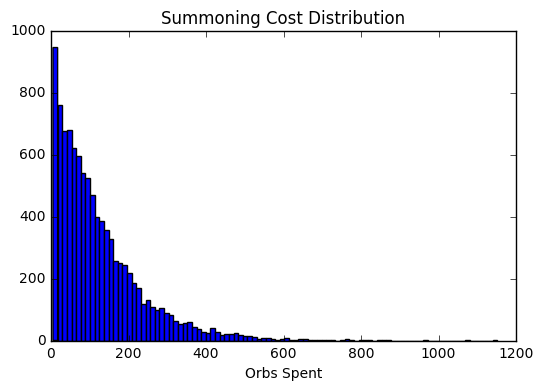

In [398]:
num_trials = float(num_trials)
np_orbs = np.array(orbs)
print("Num. Trials: %d" % num_trials)
if num_wanted > 5:
    print("0-499: %f" % (np.size(np_orbs[(np_orbs < 500)]) / num_trials))
    print("500-999: %f" % (np.size(np_orbs[(np_orbs >= 500) & (np_orbs < 1000)]) / num_trials))
    print("1000-1499: %f" % (np.size(np_orbs[(np_orbs >= 1000) & (np_orbs < 1500)]) / num_trials))
    print("1500-1999: %f" % (np.size(np_orbs[(np_orbs >= 1500) & (np_orbs < 2000)]) / num_trials))
    print("2000-2499: %f" % (np.size(np_orbs[(np_orbs >= 2000) & (np_orbs < 2500)]) / num_trials))
    print("2500-2999: %f" % (np.size(np_orbs[(np_orbs >= 2500) & (np_orbs < 3000)]) / num_trials))
    print("3000-3499: %f" % (np.size(np_orbs[(np_orbs >= 3000) & (np_orbs < 3500)]) / num_trials))
    print("3500+: %f" % (np.size(np_orbs[(np_orbs >= 3500)]) / num_trials))
else:
    print("First pull: %f" % (np.size(np_orbs[(np_orbs == 5)]) / num_trials))
    print("0-49: %f" % (np.size(np_orbs[(np_orbs < 50)]) / num_trials))
    print("50-99: %f" % (np.size(np_orbs[(np_orbs >= 50) & (np_orbs < 100)]) / num_trials))
    print("100-149: %f" % (np.size(np_orbs[(np_orbs >= 100) & (np_orbs < 150)]) / num_trials))
    print("150-199: %f" % (np.size(np_orbs[(np_orbs >= 150) & (np_orbs < 200)]) / num_trials))
    print("200-249: %f" % (np.size(np_orbs[(np_orbs >= 200) & (np_orbs < 250)]) / num_trials))
    print("250-299: %f" % (np.size(np_orbs[(np_orbs >= 250) & (np_orbs < 300)]) / num_trials))
    print("300-349: %f" % (np.size(np_orbs[(np_orbs >= 300) & (np_orbs < 350)]) / num_trials))
    print("350+: %f" % (np.size(np_orbs[(np_orbs >= 350)]) / num_trials))
print("Mean: %f" % (np.mean(np_orbs)))
print("Std. Dev.: %f" % (np.std(np_orbs)))
print("Median: %d" % (np.median(np_orbs)))
print("90th perc.: %d" % (np.percentile(np_orbs, 90)))
print("Max: %d" % (np.max(np_orbs)))

plt.hist(orbs, bins='auto')
plt.title('Summoning Cost Distribution')
plt.xlabel('Orbs Spent')

plt.show()